In [1]:
import numpy as np
load_save=np.load('./data_chung/test_result_50k.npz',allow_pickle=True)

In [2]:
r_smi=load_save['rsmi']
test_y=load_save['test_y']
test_y_pred=load_save['test_y_pred']

In [3]:
idx_false=[]
for idx,i in enumerate(test_y):
    if i != test_y_pred[idx]:
        idx_false.append(idx)

In [4]:
test_y_false=test_y[idx_false]
test_y_false=test_y_false.reshape(-1,1)
test_y_pred_false=test_y_pred[idx_false]
test_y_pred_false=test_y_pred_false.reshape(-1,1)
r_smi_false=r_smi[idx_false]
r_smi_false=r_smi_false.reshape(-1,1)
false=np.hstack((test_y_false,test_y_pred_false))

In [5]:
import pandas as pd
df=pd.DataFrame(false)
df

,0,1
0,6,3
1,36,18
2,12,11
3,16,14
4,20,18
...,...,...
966,25,11
967,21,3
968,47,12
969,29,28


In [6]:
df[0].value_counts()[:5]

0
18    169
15     75
27     73
1      61
14     61
Name: count, dtype: int64

# Check_Label_18

In [7]:
df_18=df[df.iloc[:,0]==18]
df_18[1].value_counts()[:5]

1
30    27
8     15
36     8
9      8
49     7
Name: count, dtype: int64

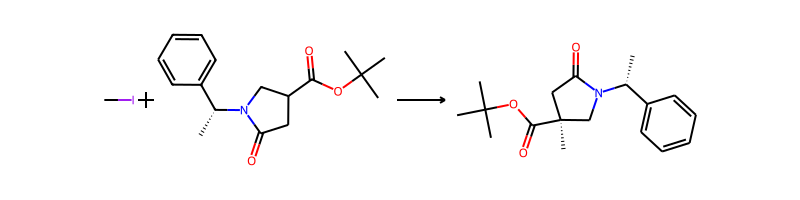

In [11]:
from rdkit.Chem import AllChem, Draw
idx_check=df_18[df_18[1]==49].index[1]
rxn=r_smi_false[idx_check][0]
rxn_chem=AllChem.ReactionFromSmarts(rxn,useSmiles=True)
Draw.ReactionToImage(rxn_chem)


18
19670


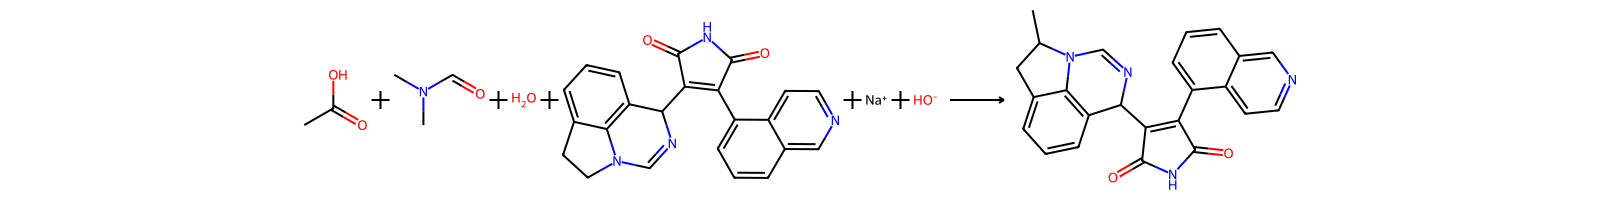

In [9]:
origin=np.load('./data_chung/data_test2.npz',allow_pickle=True)
original_reaction=origin['reaction']
idx_origin=idx_false[idx_check]
rxn=original_reaction.item()['rsmi'][idx_origin+1]
rxn_chem=AllChem.ReactionFromSmarts(rxn,useSmiles=True)
print(np.argmax(original_reaction.item()['y'][idx_origin+1]))
print(idx_origin)
Draw.ReactionToImage(rxn_chem)

# Check_label_15

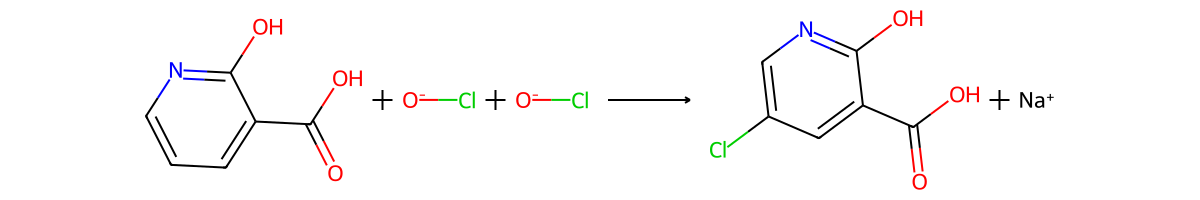

In [82]:
from rdkit.Chem import AllChem, Draw
rxn_ex_15=r_smi[test_y==15][4]
rxn_chem=AllChem.ReactionFromSmarts(rxn_ex_15,useSmiles=True)
Draw.ReactionToImage(rxn_chem)

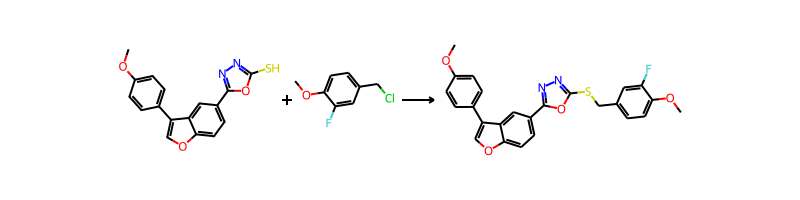

In [93]:
from rdkit.Chem import AllChem, Draw
rxn_ex_13=r_smi[test_y==13][0]
rxn_chem=AllChem.ReactionFromSmarts(rxn_ex_13,useSmiles=True)
Draw.ReactionToImage(rxn_chem)

In [76]:
df_15=df[df.iloc[:,0]==15]
df_15[1].value_counts()[:5]

1
18    23
13     8
7      6
30     5
49     5
Name: count, dtype: int64

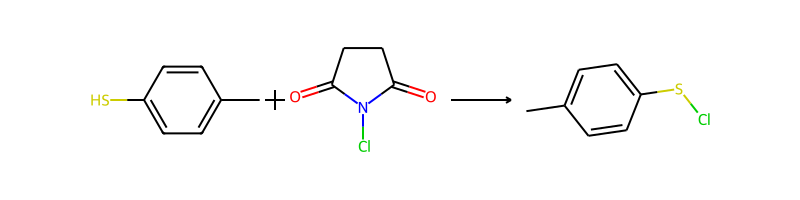

In [96]:
from rdkit.Chem import AllChem, Draw
idx_check=df_15[df_15[1]==13].index[4]
rxn=r_smi_false[idx_check][0]
rxn_chem=AllChem.ReactionFromSmarts(rxn,useSmiles=True)
Draw.ReactionToImage(rxn_chem)

15
27282


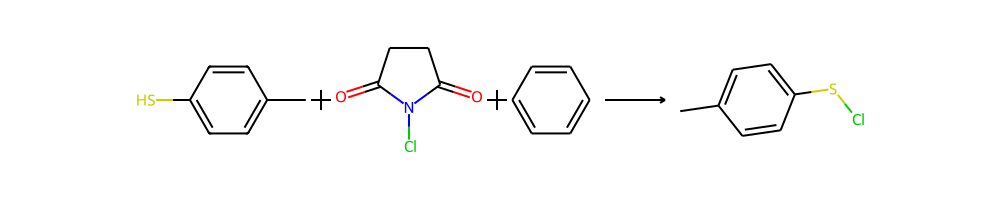

In [97]:
origin=np.load('./data_chung/data_test2.npz',allow_pickle=True)
original_reaction=origin['reaction']
idx_origin=idx_false[idx_check]
rxn=original_reaction.item()['rsmi'][idx_origin+1]
rxn_chem=AllChem.ReactionFromSmarts(rxn,useSmiles=True)
print(np.argmax(original_reaction.item()['y'][idx_origin+1]))
print(idx_origin)
Draw.ReactionToImage(rxn_chem)